Example of how to cluster HSNE hierarchies using Louvain clustering


Most of these dependencies are standard toolkit for data scientists

Not so standard:
igraph: https://igraph.org/

good implementation of louvain algorithm: https://louvain-igraph.readthedocs.io/en/latest/install.html


In [1]:
from HSNE_parser import read_HSNE_binary
import pandas as pd
import numpy as np
import igraph as ig
import louvain

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import rcParams

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix


Read the hierarchy from a HSNE binary file and print progress:

In [2]:
def run_louvain(tmatrix, **kwargs):
    weighted = kwargs['weight']
    sources, targets = tmatrix.nonzero()
    edgelist = list(zip(sources.tolist(), targets.tolist()))
    G = ig.Graph(edgelist)
    if weighted:
        G.es['weight'] = tmatrix.data
        return louvain.find_partition(G, louvain.ModularityVertexPartition, weights=G.es['weight']).membership
    else:
        return louvain.find_partition(G, louvain.ModularityVertexPartition).membership


In [3]:
hsne = read_HSNE_binary(filename="/home/paul/Stage/LDA/Data/MNIST/mnist_no_labels_train.hsne", verbose=True)

Number of scales 4
Start reading first scale of size 60000
Done reading first scale..

Next scale: 1
Scale size: 12005
Reading transmatrix..
Reading landmarks of scale to original data..
Reading landmarks to previous scale..
Reading landmark weights..
Reading previous scale to current scale..
Reading area of influence..

Next scale: 2
Scale size: 1765
Reading transmatrix..
Reading landmarks of scale to original data..
Reading landmarks to previous scale..
Reading landmark weights..
Reading previous scale to current scale..
Reading area of influence..

Next scale: 3
Scale size: 128
Reading transmatrix..
Reading landmarks of scale to original data..
Reading landmarks to previous scale..
Reading landmark weights..
Reading previous scale to current scale..
Reading area of influence..
Total time spent parsing hierarchy and building objects: 4.681071


Fetch raw MNIST data & labels

MNIST in CSV format available at: https://pjreddie.com/projects/mnist-in-csv/

In [4]:
# Read mnist data and put labels in seperate array
mnist = pd.read_csv("/home/paul/Stage/LDA/Data/MNIST/mnist_train.csv", header=None)
mnist_data = mnist.drop(columns=0)
mnist_labels = mnist[0].ravel()
del mnist

MNIST are handwritten digits 0-9 with each pixel corresponding to a grey value

Label: 5


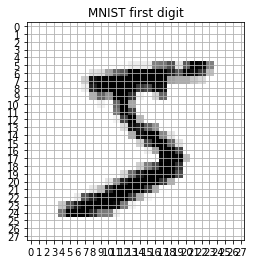

In [5]:
rcParams['figure.figsize'] = 4, 4
# Invert grey values for imshow()
inverted = np.array(np.asarray([255] * len(mnist_data.iloc[0])) - mnist_data.iloc[0])
plt.imshow(inverted.reshape(28, 28), cmap='gray')
plt.xticks([i for i in range(28)])
plt.yticks([i for i in range(28)])
plt.grid(b=True)
plt.title("MNIST first digit")
print("Label: %s" % (mnist_labels[0]))
plt.show()

Louvain Clustering on HSNE scale 2, 1765 datapoints:

note that Louvain clustering can take long on very large matrices (transition matrices of say, 200k * 200k or larger)

In [6]:
# Find the commmunity assignments that give highest modularity
clusters = run_louvain(hsne[1].tmatrix, weight=True)

In [7]:
# 11 clusters are found
set(clusters)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

In [8]:
# List where index is landmark on scale and value is cluster assignment
clusters[:30]

[8,
 3,
 7,
 6,
 8,
 5,
 1,
 6,
 3,
 5,
 8,
 12,
 3,
 5,
 9,
 2,
 0,
 9,
 3,
 7,
 0,
 7,
 5,
 6,
 0,
 6,
 3,
 3,
 12,
 2]

Calculate rand index of clustering versus labels:

In [9]:
landmark_truth = mnist_labels[np.array(hsne[1].lm_to_original)]
adjusted_rand_score(clusters, landmark_truth)

0.8805810376924695

Clustering is good; contingency matrix of clustering:

1's are split into 2 clusters of respectively 170 and 120 landmarks

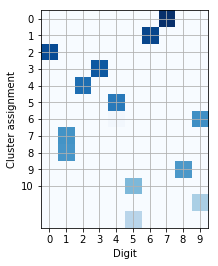

In [10]:
plt.imshow(contingency_matrix(list(clusters), landmark_truth), cmap='Blues')
plt.xticks([i for i in range(10)])
plt.yticks([ i for i in range(11)])
plt.ylabel("Cluster assignment")
plt.xlabel("Digit")
plt.grid(b=True)
plt.show()

Why are the 1's split into more clusters? 

Inspection of the average values of each cluster shows that the clustering discerns between slanted and straight 1's, the straight ones might even contain some left slanted 1's.

In [14]:
mask1 = np.array(clusters) == 7
mask2 = np.array(clusters) == 8
landmarks1 = np.array(hsne[1].lm_to_original)[mask1]
landmarks2 = np.array(hsne[1].lm_to_original)[mask2]

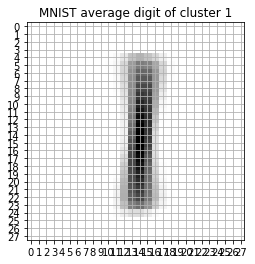

In [15]:
sum(mnist_data.iloc[landmarks1].values) / len(landmarks1)
rcParams['figure.figsize'] = 4, 4
# Invert grey values for imshow()

inverted = np.array(np.asarray([255] * len(mnist_data.iloc[0])) - sum(mnist_data.iloc[landmarks1].values) / len(landmarks1))
plt.imshow(inverted.reshape(28, 28), cmap='gray')
plt.xticks([i for i in range(28)])
plt.yticks([i for i in range(28)])
plt.grid(b=True)
plt.title("MNIST average digit of cluster 7")
plt.show()

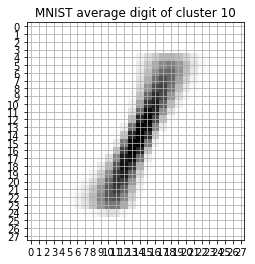

In [16]:
sum(mnist_data.iloc[landmarks2].values) / len(landmarks2)
rcParams['figure.figsize'] = 4, 4
# Invert grey values for imshow()

inverted = np.array(np.asarray([255] * len(mnist_data.iloc[0])) - sum(mnist_data.iloc[landmarks2].values) / len(landmarks1))
plt.imshow(inverted.reshape(28, 28), cmap='gray')
plt.xticks([i for i in range(28)])
plt.yticks([i for i in range(28)])
plt.grid(b=True)
plt.title("MNIST average digit of cluster 8")
plt.show()

# For how to propagate clustering of a scale back to each original datapoint, see the Markov clustering example notebook in this repository